In [1]:
import pickle
import torch
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as gnn
import torch_geometric.transforms
import torch_geometric.utils
import torch.nn.functional as F

In [2]:
data_dir = Path().absolute().parent / "data"

## Build dataframe with all node features and target classes

In [3]:
n2v_features_df = pd.read_pickle(data_dir / "embeddings/node2vec_embedding.pkl")
spec_features_df = pd.read_pickle(data_dir / "embeddings/spectral_embedding.pkl")
node_info_df = pd.read_pickle(data_dir / "preprocessed/node_info.pkl")
edge_info_df = pd.read_pickle(data_dir / "preprocessed/edge_info.pkl")
node_info_df = node_info_df[node_info_df["super_class"] != "optic"]
edge_info_df = edge_info_df[
    edge_info_df["pre_root_id"].isin(node_info_df["root_id"])
    & edge_info_df["post_root_id"].isin(node_info_df["root_id"])
]
additional_node_features = ["side", "length_nm", "area_nm", "size_nm"]
classes = ["super_class", "class", "hemilineage"]
node_info_df = node_info_df[["root_id"] + additional_node_features + classes]
node_info_df = pd.merge(
    n2v_features_df, node_info_df, how="left", left_index=True, right_on="root_id"
).set_index("root_id")
node_info_df = pd.merge(
    node_info_df, spec_features_df, how="left", left_index=True, right_index=True
)

print(f"|V|={len(node_info_df)}, |E|={len(edge_info_df)}")

|V|=51405, |E|=1301936


Encode discrete attributes/classes: side, super_class, class, hemilineage:

In [5]:
def encode_str(series, threshold=1):
    value_counts = series.value_counts()
    if pd.isna(series).any() or value_counts.min() < threshold:
        id2name = {0: "Other"}
        offset = 1
    else:
        id2name = {}
        offset = 0
    for i, (name, count) in enumerate(value_counts.items()):
        if count < threshold:
            break
        id2name[i + offset] = name
    return id2name, {v: k for k, v in id2name.items()}

Fractions of neurons with {superclass, class, subclass} labels:

In [7]:
for col in ["super_class", "class", "hemilineage"]:
    num_isna = node_info_df[col].isna().sum()
    frac_valid = 1 - (num_isna / len(node_info_df))
    num_classes = len(node_info_df[col].value_counts())
    print(f"{col}: {frac_valid * 100:.2f}% with valid label, {num_classes} classes")

super_class: 100.00% with valid label, 8 classes
class: 41.29% with valid label, 28 classes
hemilineage: 59.24% with valid label, 188 classes


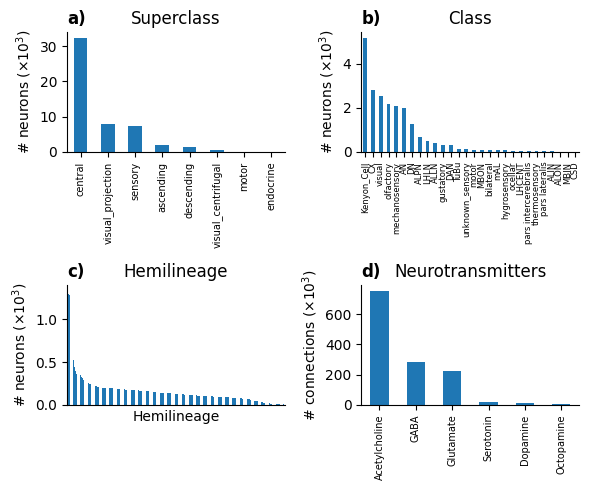

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(6, 5), tight_layout=True)

ax = axs[0, 0]
(node_info_df["super_class"].value_counts() / 1000).plot.bar(ax=ax)
ax.set_xlabel("")
ax.set_ylabel(r"# neurons ($\times 10^3$)")
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
ax.tick_params(axis="x", which="both", labelsize=7)
ax.set_title("Superclass")
ax.set_title("a)", loc="left", fontweight="bold")

ax = axs[0, 1]
(node_info_df["class"].value_counts() / 1000).plot.bar(ax=ax)
ax.tick_params(axis="x", which="both", labelsize=6)
ax.set_xlabel("")
ax.set_ylabel(r"# neurons ($\times 10^3$)")
ax.set_title("Class")
ax.set_title("b)", loc="left", fontweight="bold")

ax = axs[1, 0]
(node_info_df["hemilineage"].value_counts() / 1000).plot.bar(ax=ax)
ax.set_xlabel("Hemilineage")
ax.set_ylabel(r"# neurons ($\times 10^3$)")
ax.set_xticks([])
ax.set_title("Hemilineage")
ax.set_title("c)", loc="left", fontweight="bold")

ax = axs[1, 1]
(edge_info_df["nt_type"].value_counts() / 1000).plot.bar(ax=ax)
ax.set_xlabel("")
ax.set_ylabel(r"# connections ($\times 10^3$)")
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
nt_names = {
    "ACH": "Acetylcholine",
    "GABA": "GABA",
    "GLUT": "Glutamate",
    "SER": "Serotonin",
    "DA": "Dopamine",
    "OCT": "Octopamine",
}
ax.set_xticklabels([nt_names[x] for x in xticklabels])
ax.tick_params(axis="x", which="both", labelsize=7)
ax.set_title("Neurotransmitters")
ax.set_title("d)", loc="left", fontweight="bold")

sns.despine()
plt.savefig("../figs/node_edge_stats.pdf")

### Subsume minor classes into a single "Other" category

In [9]:
sclass_id2name, sclass_name2id = encode_str(node_info_df["super_class"], 100)
class_id2name, class_name2id = encode_str(node_info_df["class"], 100)
hemilineage_id2name, hemilineage_name2id = encode_str(node_info_df["hemilineage"], 200)

Number of categories after merging minor classes:

In [10]:
print(f"superclass: {len(sclass_id2name)} classes")
print(f"class: {len(class_id2name)} classes")
print(f"hemilineage: {len(hemilineage_id2name)} classes")

superclass: 8 classes
class: 16 classes
hemilineage: 31 classes


In [11]:
for col, id2name, name2id in [("super_class", sclass_id2name, sclass_name2id),
                              ("class", class_id2name, class_name2id),
                              ("hemilineage", hemilineage_id2name, hemilineage_name2id)]:
    node_info_df[col] = node_info_df[col].map(name2id)
    node_info_df.loc[node_info_df[col].isna(), col] = 0
    node_info_df[col] = node_info_df[col].astype(np.int64)


In [12]:
node_info_df["is_left"] = (node_info_df["side"] == "left").astype(np.int64)
node_info_df["is_right"] = (node_info_df["side"] == "right").astype(np.int64)
node_info_df.drop(columns=["side"], inplace=True)

In [13]:
node_info_df.sample(5)

,ACH_0,ACH_1,ACH_2,ACH_3,ACH_4,ACH_5,ACH_6,ACH_7,SER_0,SER_1,...,spectral_OCT_0,spectral_OCT_1,spectral_OCT_2,spectral_OCT_3,spectral_OCT_4,spectral_OCT_5,spectral_OCT_6,spectral_OCT_7,is_left,is_right
root_id,,,,,,,,,,,,,,,,,,,,,
720575940621216169,-1.367137,-0.361433,-0.762365,1.371024,0.875114,0.707266,-0.288375,-0.384860,0.032082,-0.097507,...,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092,0,1
720575940613813138,-1.793592,0.384966,0.602170,-0.742008,-0.300921,1.427335,0.011813,0.518696,-0.025339,-0.017104,...,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092,0,1
720575940623088398,-0.644356,-0.870443,0.699507,-0.028111,-1.552324,1.366228,1.652233,0.158901,-0.005860,0.063010,...,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092,0,1
720575940618630193,-1.908024,0.261060,0.558083,1.249088,-0.259225,1.293851,-1.007191,1.034670,0.089662,0.043040,...,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092,0,1
720575940616561803,-1.436208,0.902876,0.328797,0.538753,-0.337964,1.712239,-0.539385,1.942538,-0.058964,-0.070520,...,-0.004382,0.000351,-0.000193,-0.000022,-0.000082,0.000115,-0.000057,0.000092,0,1


In [14]:
num_dims_per_nt = 8
nt_types = ["ACH", "GABA", "GLUT", "SER", "DA", "OCT"]
num_node_features = len(nt_types) * num_dims_per_nt + 2 + 3

# Check the prevalence of non-neuromodulator edges
num_non_nm_edges = np.isin(edge_info_df["nt_type"], ["ACH", "GABA", "GLUT"]).sum()
print(f"Non-neuromodulator edges: {100 * num_non_nm_edges / len(edge_info_df):.2f}%")

## Convert data into a PyG graph

First, make a NetworkX graph:

In [16]:
edge_info_df.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940619238582,720575940634854554,AVLP_R,35,ACH
1,720575940634034839,720575940660217473,AL_R,38,SER
2,720575940612615570,720575940604789676,EB,26,GABA
3,720575940614901215,720575940626983952,PRW,70,GABA
4,720575940627312104,720575940625498512,SMP_R,28,GLUT


In [17]:
edge_info_new = edge_info_df.pivot_table(
    index=["pre_root_id", "post_root_id"],
    columns="nt_type",
    values="syn_count",
    fill_value=0,
)
edge_info_new.columns.name = None
edge_info_new = edge_info_new.rename(
    columns={x: f"weight_{x}" for x in edge_info_new.columns}
).reset_index()

In [18]:
nx_graph = nx.from_pandas_edgelist(
    edge_info_new,
    source="pre_root_id",
    target="post_root_id",
    edge_attr=[f"weight_{nt}" for nt in nt_types],
    create_using=nx.DiGraph,
)
nx.set_node_attributes(nx_graph, node_info_df.to_dict(orient="index"))

Convert NetworkX graph to PyG graph:

In [19]:
node_attributes_in = (
    [f"{nt}_{i}" for nt in nt_types for i in range(num_dims_per_nt)] + 
    ["is_left", "is_right", "length_nm", "area_nm", "size_nm"]
)
pg_graph = torch_geometric.utils.from_networkx(
    nx_graph,
    group_node_attrs=node_attributes_in,
    group_edge_attrs=[f"weight_{nt}" for nt in nt_types],
)

Save NX and GyG graphs:

In [20]:
graphs_dir = data_dir / "graphs"
graphs_dir.mkdir(exist_ok=True)
with open(graphs_dir / "nx_graph.pkl", "wb") as f:
    pickle.dump(nx_graph, f)
with open(graphs_dir / "pg_graph.pkl", "wb") as f:
    pickle.dump(pg_graph, f)